In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

from importlib import reload

import pdb

waves = 0.5, a = 2.4674011002723395


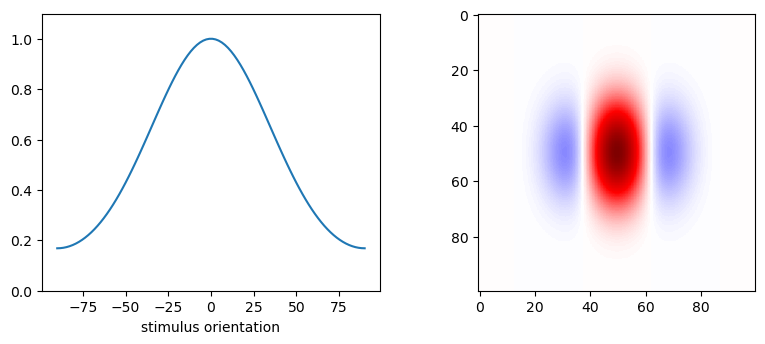

In [2]:
thets = np.linspace(-np.pi/2, np.pi/2, 100)
waves = .5 # number of waves in 2σ (full-width of Gabor)
sig_f = waves/2 
a = (2 * np.pi * sig_f)**2
print(f'{waves = }, {a = }')
fig, axs = plt.subplots(1, 2, figsize=np.array((8 * 2, 6)) * .6)
ax = axs[0]
ax.plot(thets * 180 / np.pi, np.cosh(a * np.cos(thets)) / np.cosh(a))
ax.set_ylim([0, 1.1]);
ax.set_xlabel('stimulus orientation')
ax.set_label(f'Isotropic Gabor tuning curve ({waves:.2}waves in 2σ)')
#ax.grid()
ax = axs[1]
xs = np.linspace(-4 * sig_f, 4 * sig_f, 100)
xs = np.meshgrid(xs, xs)
xs = np.array(xs)

gabor = np.exp(- 0.5 * np.sum(xs ** 2, axis=0) / sig_f**2)
gabor *= np.cos(2 * np.pi * xs[0])
ax.imshow(gabor, cmap='seismic', vmin=-np.abs(gabor).max(), vmax=np.abs(gabor).max())

In [48]:
class Gabor():
    """
    Gabor filters with specified orientation (theta), phase (phase), spatial frequency (k), 
    standard deviation (sigma), on an image pixelized to resol x resol. 
    You can optionally provide the nominal length (L) of the image as well.  
    If L is not provided, it is set to 20 * sigma.
    Also, instead of sigma, you can provide "waves" which is the number of waves contained within 2-σ
    width of the Gabor (more precisely, waves = 2 * sigma * k).
    """
    def __init__(self, theta, phase, k, sigma=None, resol=100, waves=0.5, L=None):
        self.theta = theta
        self.phase = phase
        self.k = k
        assert not (sigma is None and waves is None)
        self.sigma = sigma if waves is None else waves / 2 / k
        self.resol = resol
        self.L = L if L is not None else 20 * self.sigma

        self.filter = self.make_gabor()

    def make_gabor(self, theta=None, phase=None, k=None, sigma=None, waves=None, norm=True):
        theta = self.theta if theta is None else theta        
        phase = self.phase if phase is None else phase
        k = self.k if k is None else k
        sigma = self.sigma if sigma is None else sigma
        sigma = waves / 2 / k if waves is not None else sigma

        xs = np.linspace(-self.L/2, self.L/2, self.resol)
        xs = np.meshgrid(xs, xs)
        xs = np.array(xs)
        
        gabor = np.cos(2 * np.pi * k * (np.cos(theta) * xs[0] + np.sin(theta) * xs[1]) + phase)
        gabor *= np.exp(- 0.5 * np.sum(xs ** 2, axis=0) / sigma**2)
        if norm:
             gabor /= 2 * np.pi * sigma**2

        return gabor

In [124]:
tc_integral = lambda θ, ks, kg, φs, φg, σ: np.exp(- 2 * σ**2 * np.pi**2 * (ks**2 + kg**2)) * (
                                np.cos(φs) * np.cos(φg) * np.cosh(4 * np.pi**2 * ks * kg * σ**2 * np.cos(θ)) +
                                np.sin(φs) * np.sin(φg) * np.sinh(4 * np.pi**2 * ks * kg * σ**2 * np.cos(θ)))

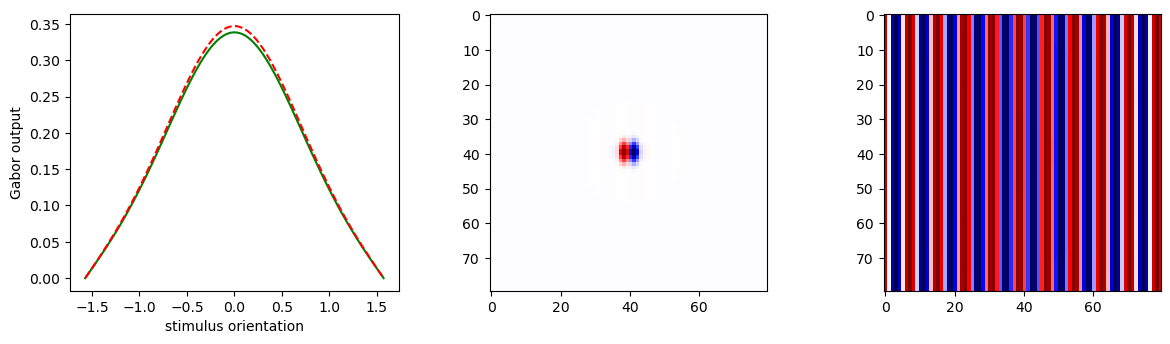

In [134]:
resol = 80
phase_g = np.pi/2 * 1.
phase_s = np.pi/2 * 1/2
gabor = Gabor(theta=0,
              phase=phase_g,
              k=2, 
              waves=.45,      # number of waves in 2σ (full-width of Gabor)
              resol=resol, 
              L=5)


fig, axs = plt.subplots(1, 3, figsize=np.array((8 * 3, 6)) * .6)
ax = axs[1]
ax.imshow(gabor.filter, cmap='seismic', vmin=-np.abs(gabor.filter).max(), vmax=np.abs(gabor.filter).max())


k_s = gabor.k

grating_fig = gabor.make_gabor(0, phase_s, k=k_s, waves=100)
ax = axs[2]
ax.imshow(grating_fig, cmap='seismic', vmin=-np.abs(grating_fig).max(), vmax=np.abs(grating_fig).max())

tun_curv = []
thetas = np.linspace(-np.pi/2, np.pi/2, 100)
for th in thetas:
    grating = gabor.make_gabor(th, phase_s, k=k_s, waves=100, norm=False)
    response = np.sum(gabor.filter * grating) * (gabor.L / gabor.resol)**2
    tun_curv.append(response)
tun_curv = np.array(tun_curv)
tc_theory = tc_integral(thetas, k_s, gabor.k, phase_s, phase_g, gabor.sigma)

normalize = False # True
ax = axs[0]
if normalize:
    tun_curv = tun_curv / tun_curv.max()
    tc_theory = tc_theory / tc_theory.max()

ax.plot(thetas, tun_curv, 'g')
ax.plot(thetas, tc_theory, 'r--') #, lw=1)
ax.set_xlabel("stimulus orientation")
ax.set_ylabel("Gabor output");